In [1]:
# Read me: 
"""
This Notebook uses 'yellow_tripdata_2013-05.csv' dataset which 
represent real taxi calls over manhetten recorded for may 2013
You can download it here: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-05.csv

How to use : 
1) Download: the csv from the link above.
2) Location: The file must be in the same directory as this notebook.
3) Run: Run all cell consecutively.


Returned values:
1) "clean_2013.csv" : all valid trips from 0000 hours Sunday, May 5,2013, to 2359 hours, Saturday May 11, 2013.
    This used to create "Request nodes" in the project , and containes 4 columns:
    
    a)   request_Index: Natural .
    b)   pickup_datetime : pd.Timestamp .
    c&d) src and dst: both : Natural .
    
    !!!! IMPORTANT !!!!
   (src and dst node ID's are matching this graph: 
    G = ox.graph_from_place('Manhattan, New York City, New York, USA', network_type='drive'))
    
2) "all_paths_nyc.pickle" : Dictionary, keyed by source and target, of shortest paths.
    display the path as a list of node ID's.


3) "all_travel_times.pickle ": (source, dictionary) iterator with dictionary keyed by target and shortest path length as the key value.

How to use : 
1) Download: the csv from the link above.
2) Location: The file must be in the same directory as this notebook.
3) Run: Run all cell consecutively.


Enjoy (=
"""


'\nThis Notebook uses \'yellow_tripdata_2013-05.csv\' dataset which \nrepresent real taxi calls over manhetten recorded for may 2013\nYou can download it here: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-05.csv\n\nHow to use : \n1) Download: the csv from the link above.\n2) Location: The file must be in the same directory as this notebook.\n3) Run: Run all cell consecutively.\n\n\nReturned values:\n1) "clean_2013.csv" : all valid trips from 0000 hours Sunday, May 5,2013, to 2359 hours, Saturday May 11, 2013.\n    This used to create "Request nodes" in the project , and containes 4 columns:\n    \n    a)   request_Index: Natural .\n    b)   pickup_datetime : pd.Timestamp .\n    c&d) src and dst: both : Natural .\n    \n    !!!! IMPORTANT !!!!\n   (src and dst node ID\'s are matching this graph: \n    G = ox.graph_from_place(\'Manhattan, New York City, New York, USA\', network_type=\'drive\'))\n    \n2) "all_paths_nyc.pickle" : Dictionary, keyed by source and target, 

In [2]:
import pandas as pd
import collections
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__
import pandas as pd
import datetime
from datetime import datetime
from datetime import timedelta
import pickle


In [3]:
# Making request from real nyc taxi data , for Simulation

In [4]:
# Getting the Data
df2013 = pd.read_csv('yellow_tripdata_2013-05.csv')
# Sorting by pickupo time
df2013 = df2013.sort_values(by=['pickup_datetime'])
print(df2013.head())

/home/roie/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


         vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
10661523       VTS  2013-05-01 00:00:00  2013-05-01 00:12:00                1   
10638632       VTS  2013-05-01 00:00:00  2013-05-01 00:24:00                1   
10634665       VTS  2013-05-01 00:00:00  2013-05-01 00:07:00                1   
10634664       VTS  2013-05-01 00:00:00  2013-05-01 00:08:00                1   
10643988       VTS  2013-05-01 00:00:00  2013-05-01 00:27:00                3   

          trip_distance  pickup_longitude  pickup_latitude  rate_code  \
10661523           2.61        -73.986757        40.742767          1   
10638632          12.90        -73.988747        40.736955          1   
10634665           2.60        -73.991260        40.745135          1   
10634664           1.29        -74.000580        40.742137          1   
10643988           6.48        -73.983583        40.761282          1   

         store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_t

In [5]:
# Parser func
def str_to_time(s):
    t = pd.Timestamp(s)
    tt = t.to_pydatetime()
    return tt
    
def str_to_time_list(s):
    time_list = []
    for t_string in s :
        time_list.append(str_to_time(t_string))
    return time_list

In [9]:
# Parse pickup_datetime string to pd.Timestamp()
df2013['pickup_datetime'] =str_to_time_list(df2013['pickup_datetime'])
df2013['dropoff_datetime'] =str_to_time_list(df2013['dropoff_datetime']) 

In [10]:
# Filter only the requests from 0000 hours Sunday, May 5,2013, to 2359 hours, Saturday May 11, 2013,
df2013 = df2013[df2013.pickup_datetime > pd.Timestamp(2013, 5, 5, 0)  ]
df2013 = df2013[df2013.dropoff_datetime < pd.Timestamp(2013, 5, 11, 23,59) ]


In [11]:
# Drops rows with bad data (bad ccordinates)

df2013 = df2013[df2013.pickup_longitude != 0]
df2013 = df2013[df2013.pickup_latitude != 0]
df2013 = df2013[df2013.dropoff_longitude != 0]
df2013 = df2013[df2013.dropoff_latitude != 0]
df2013 = df2013[df2013.passenger_count != 0]

df2013.dropna()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
8265950,CMT,2013-05-05 00:00:01,2013-05-05 00:16:39,1,3.3,-73.969635,40.752034,1,N,-74.003017,40.733278,CRD,14.0,0.5,0.5,3.0,0.0,18.0
8940596,CMT,2013-05-05 00:00:01,2013-05-05 00:02:55,2,0.4,-73.979877,40.726943,1,N,-73.982349,40.731810,CSH,4.0,0.5,0.5,0.0,0.0,5.0
8265322,CMT,2013-05-05 00:00:01,2013-05-05 00:18:06,1,2.9,-73.951133,40.710833,1,N,-73.980719,40.729852,CRD,14.5,0.5,0.5,3.1,0.0,18.6
8927973,CMT,2013-05-05 00:00:01,2013-05-05 00:08:53,1,1.3,-73.978998,40.767025,1,N,-73.988513,40.758998,CSH,7.5,0.5,0.5,0.0,0.0,8.5
8946795,CMT,2013-05-05 00:00:01,2013-05-05 00:02:27,1,0.5,-73.985484,40.741528,1,N,-73.981604,40.747176,CSH,4.0,0.5,0.5,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11749640,CMT,2013-05-11 23:56:16,2013-05-11 23:57:46,1,0.2,-73.979624,40.746354,1,N,-73.983221,40.747901,CSH,3.0,0.5,0.5,0.0,0.0,4.0
11758559,CMT,2013-05-11 23:56:21,2013-05-11 23:57:33,2,0.5,-73.963026,40.775122,1,N,-73.957686,40.782174,CSH,3.5,0.5,0.5,0.0,0.0,4.5
9834676,CMT,2013-05-11 23:56:26,2013-05-11 23:58:00,2,0.8,-73.965043,40.761847,1,N,-73.956668,40.767064,CRD,5.0,0.5,0.5,1.0,0.0,7.0
9845923,CMT,2013-05-11 23:56:46,2013-05-11 23:58:57,1,2.8,-73.977482,40.754201,4,N,-73.970842,40.752742,CRD,3.5,0.5,0.5,2.0,0.0,6.5


In [9]:
#Drop out of bound pick up and dropoff
df2013 = df2013[df2013.pickup_longitude > -74.022 ]
df2013 = df2013[df2013.pickup_latitude > 40.69]
df2013 = df2013[df2013.dropoff_longitude > -74.022]
df2013 = df2013[df2013.dropoff_latitude > 40.69]
df2013 = df2013[df2013.pickup_longitude < -73.906 ]
df2013 = df2013[df2013.pickup_latitude < 40.88]
df2013 = df2013[df2013.dropoff_longitude < -73.906]
df2013 = df2013[df2013.dropoff_latitude < 40.88]


In [10]:
# Drop unwanted columns
df2013=df2013.drop(columns=['vendor_id','trip_distance','rate_code','store_and_fwd_flag','payment_type','fare_amount','surcharge','mta_tax','tip_amount','tolls_amount','total_amount','passenger_count'])

In [11]:
df2013.head()

In [12]:
df2013.tail()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
11758559,CMT,2013-05-11 23:56:21,2013-05-11 23:57:33,2,0.50,-73.963026,40.775122,1,N,-73.957686,40.782174,CSH,3.5,0.5,0.5,0.0,0.0,4.5
9834676,CMT,2013-05-11 23:56:26,2013-05-11 23:58:00,2,0.80,-73.965043,40.761847,1,N,-73.956668,40.767064,CRD,5.0,0.5,0.5,1.0,0.0,7.0
9845923,CMT,2013-05-11 23:56:46,2013-05-11 23:58:57,1,2.80,-73.977482,40.754201,4,N,-73.970842,40.752742,CRD,3.5,0.5,0.5,2.0,0.0,6.5
1666870,VTS,2013-05-11 23:57:00,2013-05-11 23:58:00,1,0.17,-73.994162,40.690617,1,NaN,-73.992267,40.690507,CSH,3.0,0.5,0.5,0.0,0.0,4.0
11506357,CMT,2013-05-11 23:57:45,2013-05-11 23:58:07,1,0.00,-73.981826,40.740716,1,N,-73.981825,40.740717,DIS,2.5,0.5,0.5,0.0,0.0,3.5


<class 'networkx.classes.multidigraph.MultiDiGraph'>


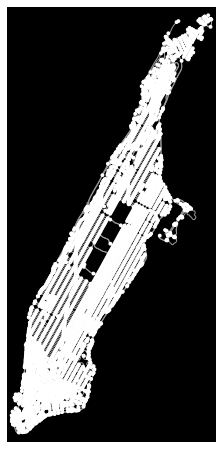

In [12]:
# New York map for processing
G = ox.graph_from_place('Manhattan, New York City, New York, USA', network_type='drive')
print(type(G))
fig, ax = ox.plot_graph(G, node_zorder=2, node_color='w', bgcolor='k')


In [13]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [14]:
#ox.stats.basic_stats(G)

In [15]:
# Adding df2013['src'] & df2013['dst']
# get the nearest network nodes to two points
df2013['src'] = ox.distance.nearest_nodes(G, df2013['pickup_longitude'], df2013['pickup_latitude']) 
df2013['dst'] = ox.distance.nearest_nodes(G, df2013['dropoff_longitude'], df2013['dropoff_latitude'])

In [16]:
df2013.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,src,dst
8383812,2013-05-01 00:00:01,2013-05-01 00:05:12,-73.991351,40.727725,-73.979983,40.743117,1773121034,42445413
8396869,2013-05-01 00:00:01,2013-05-01 00:06:36,-73.975554,40.751772,-73.955469,40.768755,42446971,42438805
8388444,2013-05-01 00:00:01,2013-05-01 00:11:14,-74.007528,40.740975,-73.988808,40.745034,42429412,42428223
7713737,2013-05-01 00:00:03,2013-05-01 00:20:39,-74.006689,40.744307,-73.926799,40.765889,42439286,1331391393
8407687,2013-05-01 00:00:03,2013-05-01 00:07:38,-73.981092,40.759499,-73.958245,40.772842,42430356,42446472


In [17]:
# Drop unwanted columns
df2013=df2013.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_datetime'])

In [18]:
# Checking if every src node and every dst node are indeed in our graph G
validity = True
graph_nodes = G.nodes()
for s_id in df2013['src']:
    if s_id not in graph_nodes:
        validity = Flase  
    
for s_id in df2013['dst']:
    if s_id not in graph_nodes:
        validity = Flase
if validity:
    print('src and dst are valid')
else:
    print('There is a bad src or dst')

src and dst are valid


In [19]:
# Saving the df as csv
df2013.to_csv('clean_2013.csv' , index=False )

In [20]:
# Shortest paths map generator

In [21]:

#Testing if shortest paths match
#route = nx.shortest_path(G, 1773121034, 42445413, 'travel_time')
#print(route)
#route_map = ox.plot_route_folium(G, route)

In [22]:
#travel_times = dict(nx.all_pairs_bellman_ford_path_length(G,weight='travel_times'))

In [23]:
#path = dict(nx.all_pairs_bellman_ford_path(G),weight='travel_times')


In [24]:
#print(path[1773121034][42445413])
#print(type(path))

In [25]:
#Saving the path map
#with open('all_paths_nyc.pickle ', 'wb') as handle:
  #  pickle.dump(path, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [26]:
#Saving the travel_times map
#with open('all_travel_times.pickle ', 'wb') as handle:
   # pickle.dump(travel_times, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [27]:
#with open('all_paths_nyc.pickle ', 'rb') as handle:
   # b = pickle.load(handle)
